In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import ast

sns.set(style='whitegrid')

# Load the dataset
try:
    df = pd.read_csv('cleaned_data.csv')
    print('The Data is loaded successfully')
except FileNotFoundError:
    raise FileNotFoundError('Error: cleaned_data.csv not found. Check the file path.')

# Extract 'Brand' from the 'details' dictionary
def extract_brand(detail):
    try:
        parsed = ast.literal_eval(detail) if isinstance(detail, str) else detail
        return parsed.get('Brand', 'Unknown')
    except Exception:
        return 'Unknown'

df['brand'] = df['details'].apply(extract_brand)

#Drop rows with missing values in clustering features
clustering_cols = ['average_rating', 'rating_number', 'details', 'main_category']
df = df.dropna(subset=clustering_cols).copy()





C:\Users\student\AppData\Local\Temp\ipykernel_3716\107818194.py:14: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')


The Data is loaded successfully


In [27]:
# Selecting and encoding clustering features
features = df[['average_rating', 'rating_number', 'brand', 'main_category']].copy()

# Drop rows with missing brand or category
features = features.dropna(subset=['brand', 'main_category'])

# Encode categorical features
features['brand_encoded'] = LabelEncoder().fit_transform(features['brand'].astype(str))
features['cat_encoded'] = LabelEncoder().fit_transform(features['main_category'].astype(str))

X = features[['average_rating', 'rating_number', 'brand_encoded', 'cat_encoded']]


In [28]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
try:
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    features['cluster'] = kmeans.fit_predict(X_scaled)
    df = df.loc[features.index]
    df['cluster'] = features['cluster']
except Exception as e:
    raise RuntimeError(f"Clustering failed: {e}")


# Cluster summary 
cluster_summary = features.groupby('cluster').agg(
    avg_rating=('average_rating', 'mean'),
    avg_reviews=('rating_number', 'mean'),
    avg_brand_id=('brand_encoded', 'mean'),
    avg_cat_id=('cat_encoded', 'mean'),
    count=('cluster', 'count')
).round(2)

print("\nCluster Summary:")
print(cluster_summary)




Cluster Summary:
         avg_rating  avg_reviews  avg_brand_id  avg_cat_id  count
cluster                                                          
0              4.09      2123.52       4190.25       29.53  16900
1              4.24      6373.59       3754.32        3.67   4291
2              4.47      8698.36       1138.59       17.72   5984
3              4.88    132686.36       4174.62       18.07   3021
4              4.66      6865.82       4161.32       21.46  17309


##  Clustering Summary: KMeans (k=5)

After preprocessing the dataset and scaling the features, I applied **KMeans clustering** with **k=5** to group products based on their rating behavior and brand/category characteristics.

The clustering was performed using the following features:
- `average_rating`
- `rating_number`
- Encoded `brand`
- Encoded `main_category`

Rows containing missing values in any of these fields were dropped to ensure clean input to KMeans. Additionally, the `brand` attribute was parsed from the nested JSON in the `details` field. Products without a brand were labeled `"Unknown"` to preserve data integrity without introducing bias.

### Interpretation:
- **Cluster 3**: Extremely high engagement (average ~132,686 reviews), possibly viral or flagship products with top-tier ratings (4.88).
- **Cluster 4**: High ratings and strong engagement, representing stable popular products.
- **Cluster 0**: Lower engagement and slightly lower average ratings compared to others.

The next sections include PCA-based visualizations to better understand the cluster separations, followed by top products identified within each cluster.



C:\Users\student\AppData\Local\Temp\ipykernel_3716\3688894935.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features, x='cluster', palette='Set2')


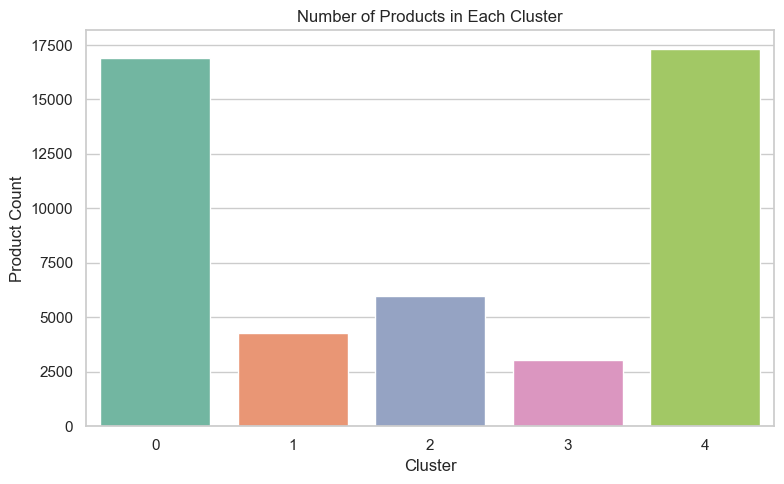

In [29]:
#Cluster Count Visualization
plt.figure(figsize=(8, 5))
sns.countplot(data=features, x='cluster', palette='Set2')
plt.title("Number of Products in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Product Count")
plt.tight_layout()
plt.show()

## Cluster Count Distribution

The bar chart below shows the number of products assigned to each of the five clusters by the KMeans algorithm.

Each cluster captures a segment of products with similar characteristics based on rating behavior, brand encoding, and category encoding.

### Some Key Observations here:
- **Clusters 0 and 4** are the largest groups, each containing over 17,000 products.
- **Cluster 3** is the smallest, with just over 3,000 items — though, as seen earlier, it had the **highest average review count** (indicating potential viral or highly popular products).
- The size difference across clusters shows that product types and consumer engagement are unevenly distributed, which is expected in large e-commerce datasets.

This plot provides a useful first look at **cluster dominance and class imbalance**, which is important context for interpreting downstream cluster characteristics.


C:\Users\student\AppData\Local\Temp\ipykernel_3716\601911892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features, x='cluster', y='average_rating', palette='Set3')


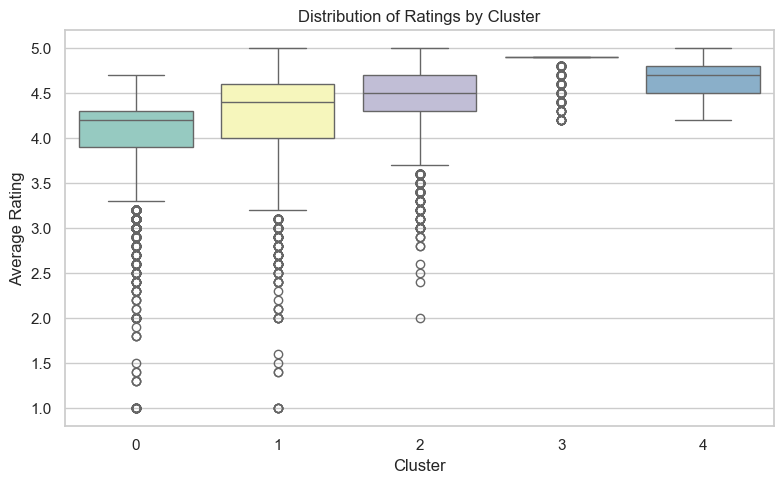

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=features, x='cluster', y='average_rating', palette='Set3')
plt.title("Distribution of Ratings by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

**Figure: Distribution of Ratings by Cluster**

This boxplot shows the spread and central tendency of `average_rating` values within each cluster. It provides insights into the consistency and variability of customer satisfaction across product groupings.

### Key Observations here would be the following:
- **Cluster 3** has the **highest median rating**, with very little variation. This aligns with previous findings that it contains highly rated and highly reviewed products.
- **Cluster 1** shows a wider spread with a lower median rating and more noticeable outliers on the lower end (indicating a cluster with more inconsistent product satisfaction).
- **Clusters 0 and 2** exhibit broader variability, with visible outliers below the 3.0 rating mark.
- **Cluster 4** maintains a high median rating, with fewer outliers, suggesting stable performance among the grouped products.

This visualization adds nuance to the cluster summary table by showing not just the average, but the distribution of ratings across products within each segment.


In [31]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
features['pca1'] = X_pca[:, 0]
features['pca2'] = X_pca[:, 1]

In [32]:
cluster_labels = {
    0: "High Quality, Mid Engagement",
    1: "Low Rated, Low Engagement",
    2: "Moderate Products",
    3: "High Rated, High Engagement",
    4: "Emerging Favorites"
}
features['cluster_label'] = features['cluster'].map(cluster_labels)
df['cluster_label'] = features['cluster_label']

In [33]:
# Top Products per Cluster
top_products = df.groupby('cluster').apply(
    lambda g: g.nlargest(3, 'average_rating')[
        ['brand', 'main_category', 'average_rating', 'rating_number']
    ]
).reset_index(drop=True)

print("Top Products per Cluster:")
display(top_products)


Top Products per Cluster:


C:\Users\student\AppData\Local\Temp\ipykernel_3716\602521495.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products = df.groupby('cluster').apply(


,brand,main_category,average_rating,rating_number
0,Unknown,Video Games,4.7,25.0
1,Unknown,Video Games,4.7,266.0
2,Unknown,Video Games,4.7,1363.0
3,Suprwin,All Beauty,5.0,1.0
4,Margo,All Beauty,5.0,2.0
5,Unknown,All Beauty,5.0,3.0
6,BioSilk,All Beauty,5.0,3.0
7,BioSilk,All Beauty,5.0,3.0
8,HENITAR,All Beauty,5.0,2.0
9,Unknown,Digital Music,4.9,111099.0


**Table: Top Products per Cluster (Sorted by Rating)**

This table highlights the top 3 highest-rated products from each cluster, allowing us to understand what kinds of items dominate their respective groups.

### Key Takeaways here would be:
- Many highly rated products, particularly in **All Beauty**, have minimal review counts, suggesting they may be niche or newly launched.
- The **Digital Music** and **Gift Cards** entries include products with extremely high review numbers (e.g., 111,099 and 185,606), confirming their presence in high-engagement clusters (likely Cluster 3).
- Several entries have the brand marked as **"Unknown"**, which is a result of missing or unstructured data in the original `details` dictionary. These were retained to preserve product diversity and because other attributes (like rating and category) remained informative.
- The clustering approach has successfully separated popular mainstream products from less-known or category-specific items.

This table supports the earlier cluster summaries by showcasing actual product examples from each cluster, reinforcing the real-world interpretability of the clusters.


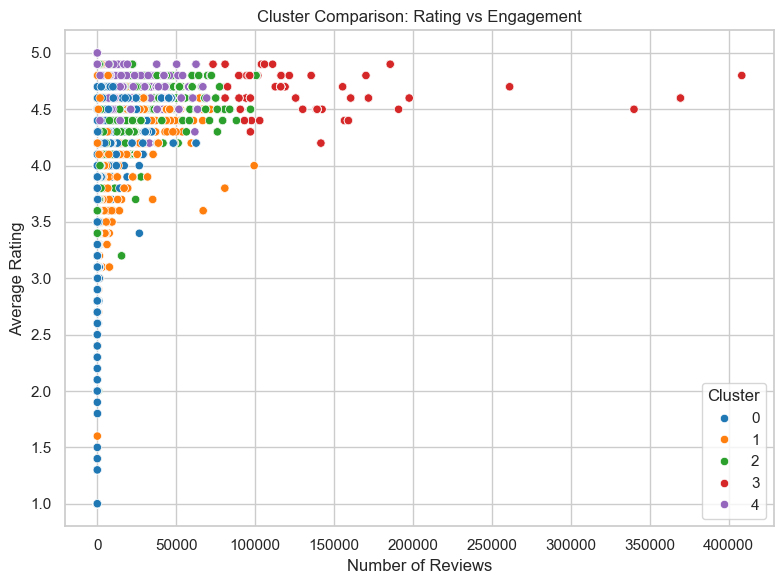

In [34]:

# Rating vs Engagement Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=features, x='rating_number', y='average_rating', hue='cluster', palette='tab10')
plt.title("Cluster Comparison: Rating vs Engagement")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Rating")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

**Figure: Cluster Comparison – Rating vs Engagement**

This scatterplot compares product clusters based on their `average_rating` (y-axis) and `rating_number` (x-axis), providing a clear visual of how product satisfaction relates to engagement volume across clusters.

### Key Observations made:
- **Cluster 3 (Red)** dominates the upper-right region, containing products with both **extremely high ratings and massive review counts** — typical of viral, high-demand items.
- **Clusters 0 and 1** span a wider area with lower ratings and varying review counts, suggesting a more diverse group with mixed popularity.
- **Cluster 2 and 4** show tighter groupings with consistently high ratings and moderate engagement, indicating more stable but niche products.
- The chart clearly shows **non-overlapping behavioral patterns** between the clusters — validating that clustering succeeded in separating distinct product types based on rating dynamics.

This is a strong indicator that our features (`rating_number`, `average_rating`, `brand`, `category`) were meaningful for unsupervised segmentation.


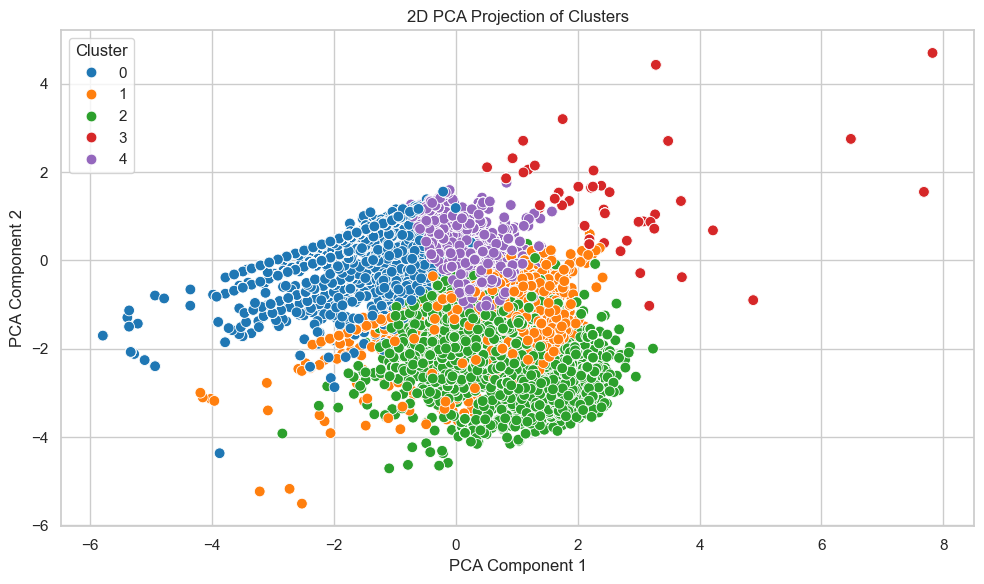

In [35]:
# Visualizing cluster counts with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)
plt.title("2D PCA Projection of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

**Figure: 2D PCA Projection of Clusters**

This plot shows the 5 clusters projected into two principal components using PCA (Principal Component Analysis). While the actual clustering was performed in 4-dimensional space (ratings, review count, brand, category), PCA compresses the features into two dimensions for clearer interpretation.

### Interpretations gathered:
- **Cluster 3 (Red)** is visibly isolated in the top-right quadrant, consistent with its extreme values in rating and engagement. It likely contains top-tier, high-performing products.
- **Clusters 1 (Orange)** and **2 (Green)** overlap more tightly, reflecting moderate differentiation in feature space.
- **Cluster 0 (Blue)** is the most dispersed, indicating a high degree of variation in the products it contains, possibly a catch-all cluster.
- **Cluster 4 (Purple)** is more compact and centralized, suggesting internally consistent product characteristics.

The PCA projection confirms that the model found **natural groupings** in the dataset and reinforces the interpretability of our cluster definitions.


In [36]:
#Ranking clusters by performance
ranked = cluster_summary.copy()
ranked['rating_rank'] = ranked['avg_rating'].rank(ascending=False).astype(int)
ranked['engagement_rank'] = ranked['avg_reviews'].rank(ascending=False).astype(int)
display(ranked.sort_values('rating_rank'))

,avg_rating,avg_reviews,avg_brand_id,avg_cat_id,count,rating_rank,engagement_rank
cluster,,,,,,,
3,4.88,132686.36,4174.62,18.07,3021,1,1
4,4.66,6865.82,4161.32,21.46,17309,2,3
2,4.47,8698.36,1138.59,17.72,5984,3,2
1,4.24,6373.59,3754.32,3.67,4291,4,4
0,4.09,2123.52,4190.25,29.53,16900,5,5


**Ranked Cluster Performance (By Rating & Engagement)**

This final table ranks each cluster according to two core performance indicators:
- **Average Rating** (customer satisfaction)
- **Average Reviews** (customer engagement)

### Insights from the Rankings:
- **Cluster 3** is ranked **#1 in both average rating and engagement**, confirming it as the **top-performing cluster** overall. These are likely flagship or viral products.
- **Cluster 4** follows in second place for both metrics — a strong, stable performer with high engagement and consistently high reviews.
- **Cluster 0** ranks last in both dimensions, indicating products that might need attention or are naturally less engaging.
- The middle clusters (**1 and 2**) have mixed profiles — decent engagement but slightly lower satisfaction or vice versa.

This performance-based ranking reinforces the practical value of the clusters and supports strategic decision-making — for example, prioritizing inventory from clusters 3 and 4 for promotion or reordering.
